# Heart Failure Prediction using Machine Learning

## Import Libraries 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from collections import Counter
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import xgboost as xgb
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import classification_report

## Explore Dataset

In [3]:
path = "/kaggle/input/heart-failure-prediction/heart.csv"
df = pd.read_csv(path)

In [4]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [5]:
df.shape

(918, 12)

In this dataset,
    there are 918 rows and 12 columns

    Age, Sex, ChestPainType, RestingBP, Cholesterol, FastingBS, RestingECG, MaxHR, ExerciseAngina, Oldpeak, ST_Slope, HeartDisease

    Here, HeartDiseases is the target column, and the remaining columns are feature variables.

In [6]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


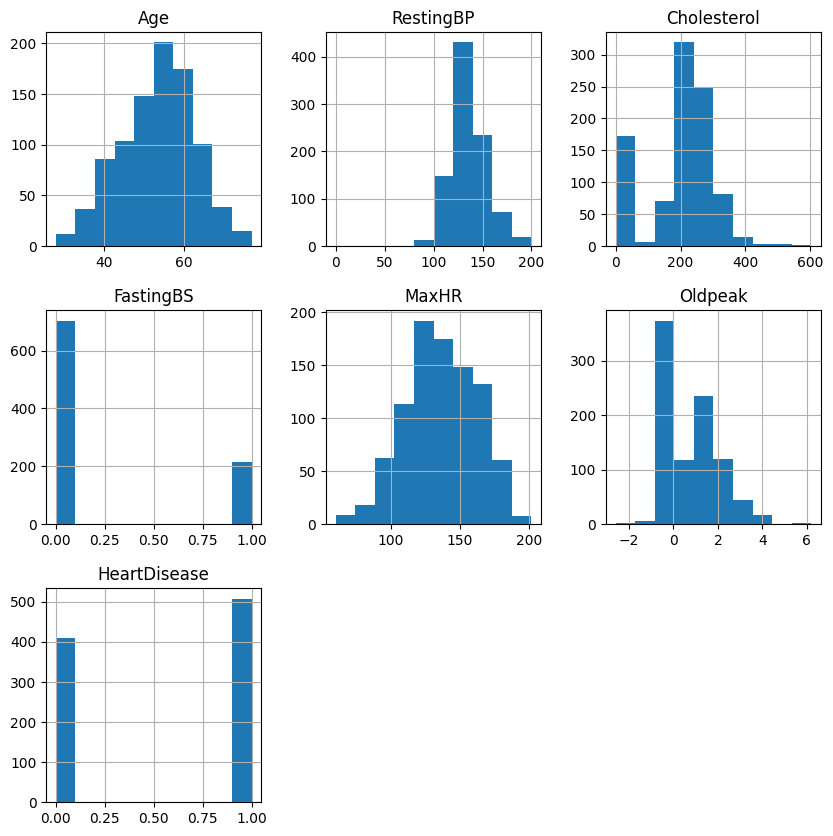

In [8]:
# Histogram
df.hist(bins=10,figsize=(10,10))
plt.show()

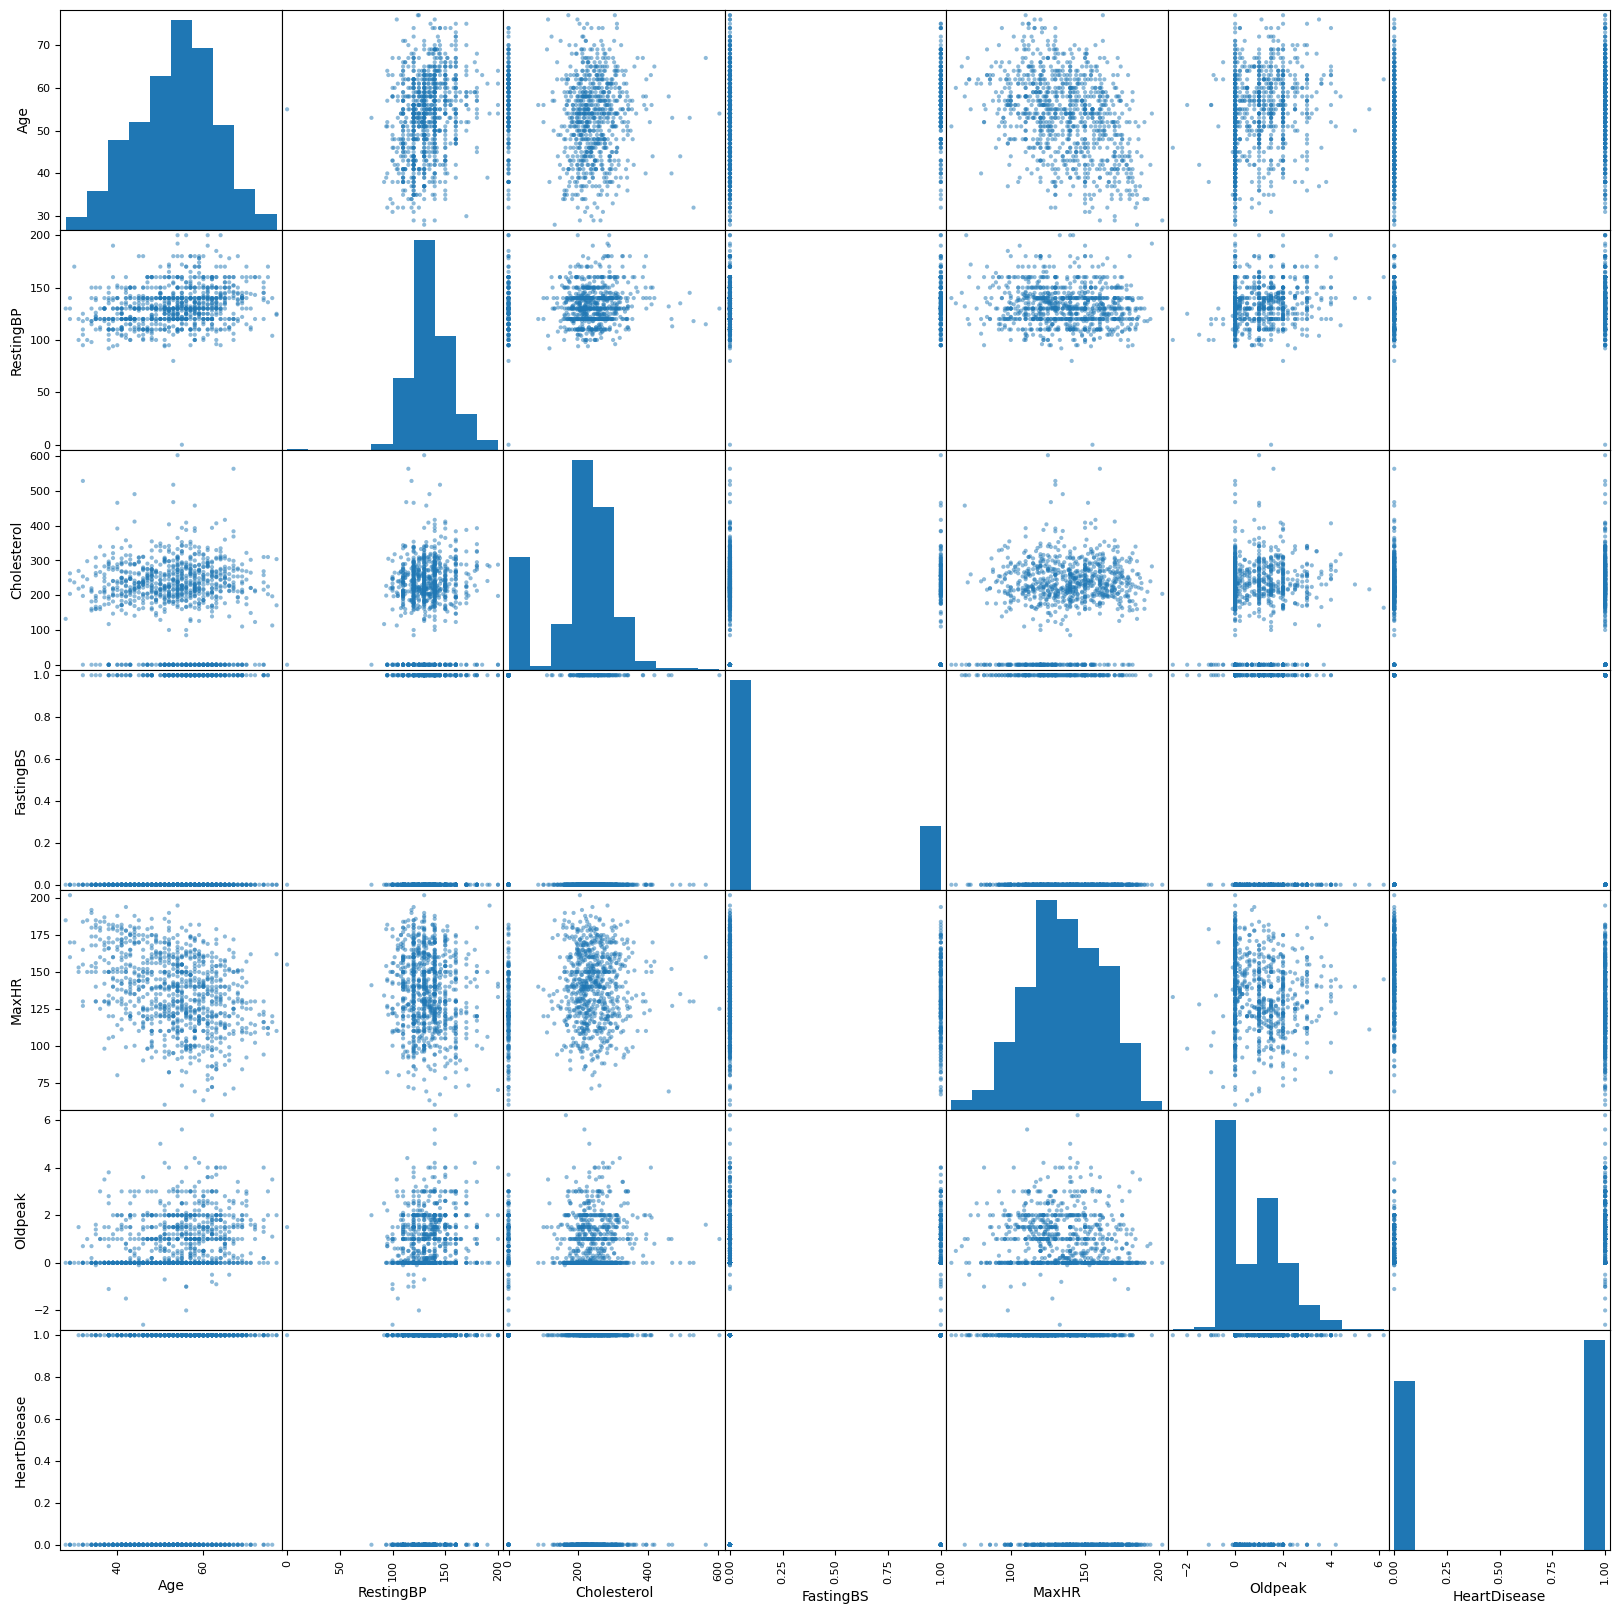

In [9]:
# Scatter plot
from pandas.plotting import scatter_matrix
scatter_matrix(df,figsize=(20,20));

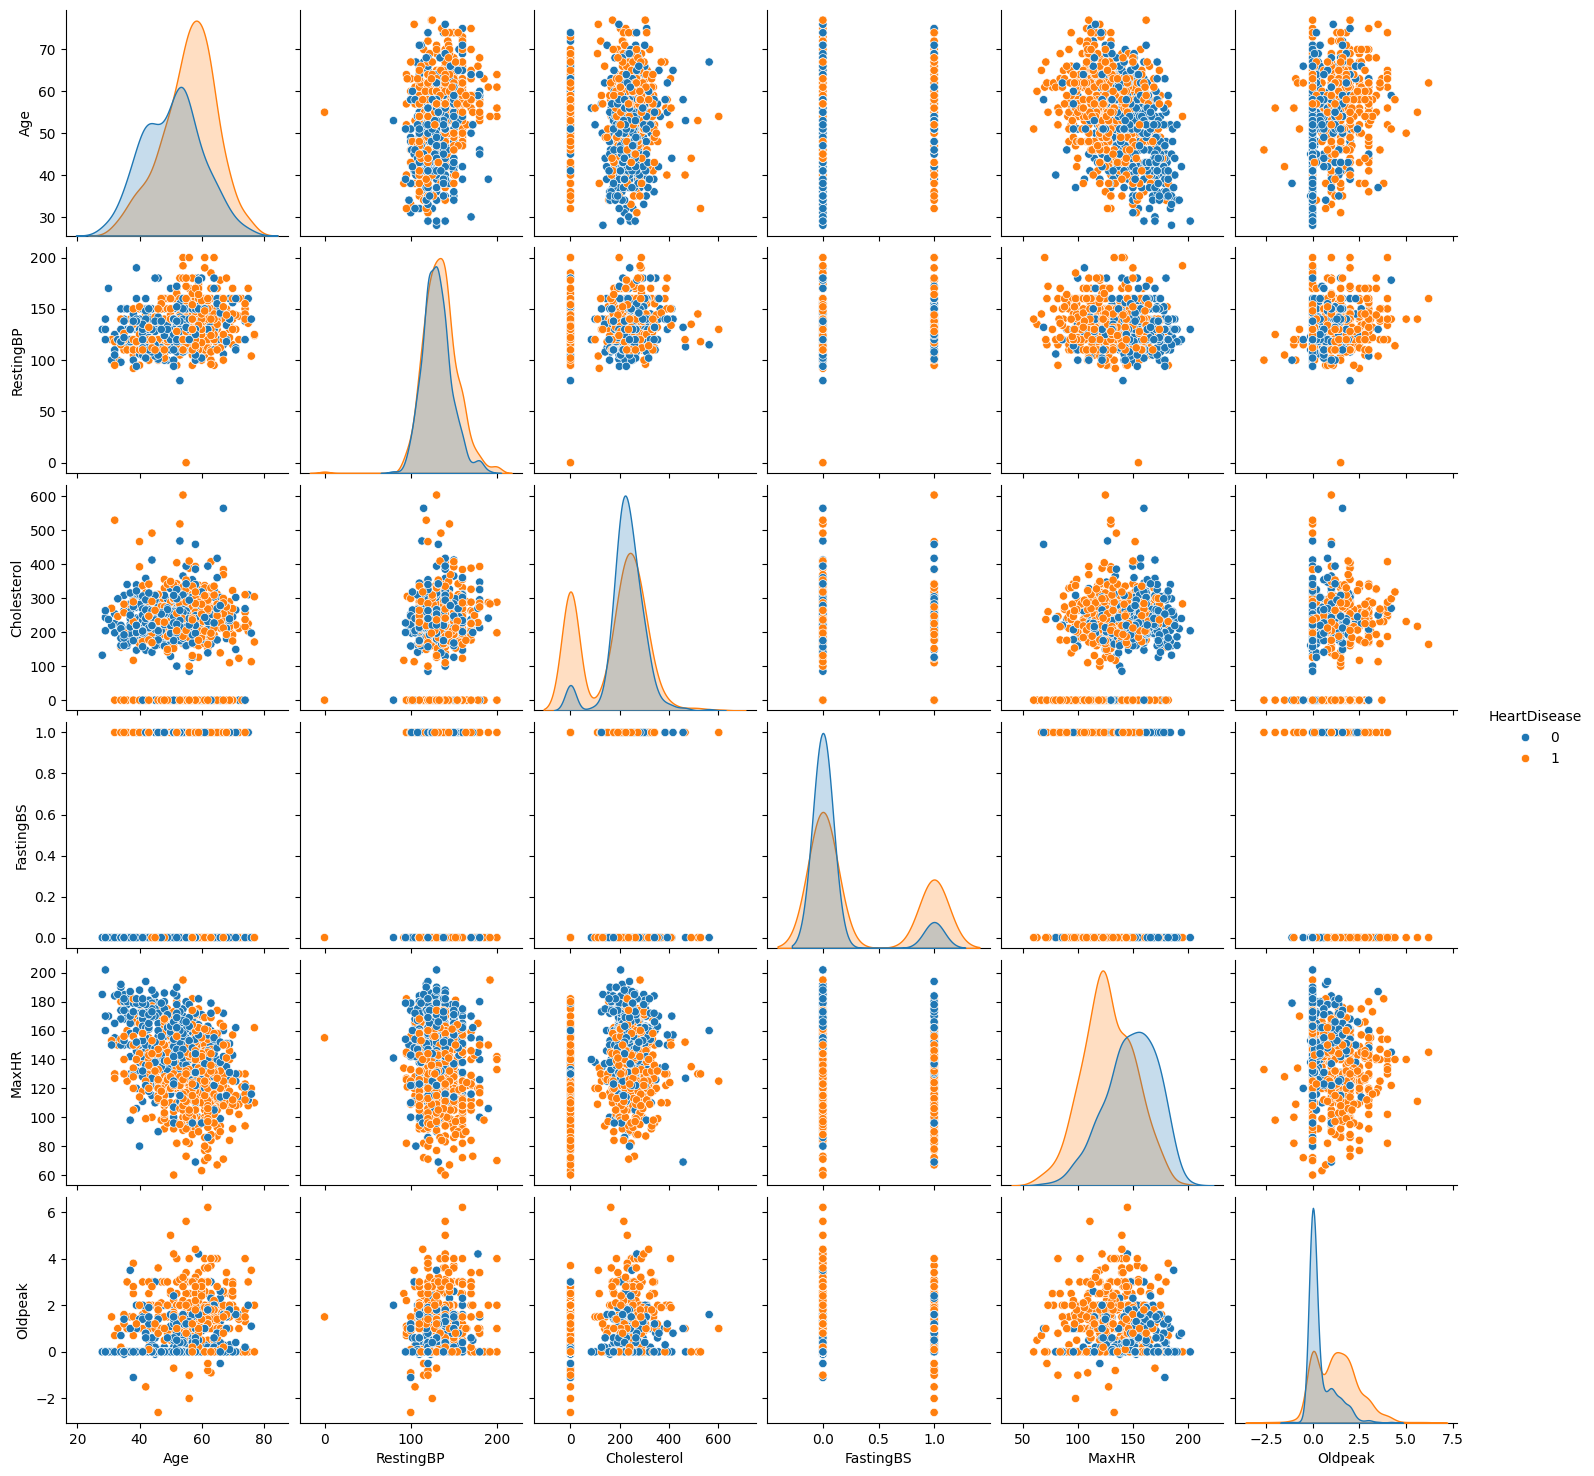

In [10]:
# Pair plot
sns.pairplot(data=df,hue='HeartDisease')
plt.show()

Normal (0):  508
Heart Disease (1):  410


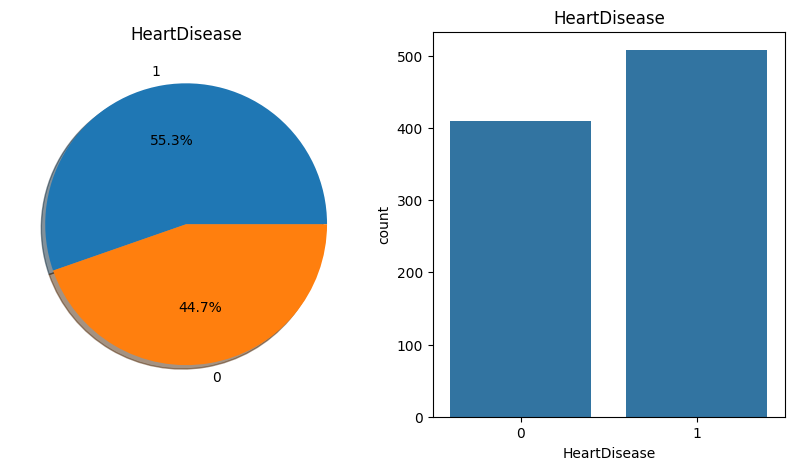

In [11]:
# Class distribution 
f,ax=plt.subplots(1,2,figsize=(10,5))
df['HeartDisease'].value_counts().plot.pie(explode=[0,0],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('HeartDisease')
ax[0].set_ylabel('')
sns.countplot(x=df["HeartDisease"])
ax[1].set_title('HeartDisease')
l,m =df['HeartDisease'].value_counts()
print('Normal (0): ',l)
print('Heart Disease (1): ',m)
plt.grid(False)
plt.show()

## Data Preprocessing

In [12]:
print(df.isnull().sum())

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


In [13]:
print("Number of duplicate rows:", df.duplicated().sum())

Number of duplicate rows: 0


In [14]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
print("Numerical Columns:")
print(list(numerical_cols))

categorical_cols = df.select_dtypes(include=['object']).columns
print("\nCategorical Columns:")
print(list(categorical_cols))

Numerical Columns:
['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'HeartDisease']

Categorical Columns:
['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']


In [15]:
print("Unique values in categorical columns:")

for col in categorical_cols:
    unique_values = df[col].unique()
    print(f"\n{col}: {len(unique_values)} unique values")
    print(unique_values)

Unique values in categorical columns:

Sex: 2 unique values
['M' 'F']

ChestPainType: 4 unique values
['ATA' 'NAP' 'ASY' 'TA']

RestingECG: 3 unique values
['Normal' 'ST' 'LVH']

ExerciseAngina: 2 unique values
['N' 'Y']

ST_Slope: 3 unique values
['Up' 'Flat' 'Down']


## Data Encoding (One-hot)

In [16]:
df = pd.get_dummies(df, columns=categorical_cols, drop_first=False, dtype=int)
df.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,...,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,1
1,49,160,180,0,156,1.0,1,1,0,0,...,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.0,0,0,1,0,...,0,0,0,0,1,1,0,0,0,1
3,48,138,214,0,108,1.5,1,1,0,1,...,0,0,0,1,0,0,1,0,1,0
4,54,150,195,0,122,0.0,0,0,1,0,...,1,0,0,1,0,1,0,0,0,1


## Define Features (X) and Target (y)

In [17]:
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (918, 20)
y shape: (918,)


## Classifiers

In [18]:
classifiers = {
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(),
    "ridge_clf": RidgeClassifier(alpha=1),
    "Logistic Regression": LogisticRegression(max_iter=4000),
    "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
    "Random Forest": RandomForestClassifier(),
    "Xgboost": xgb.XGBClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier()
}

## Cross Validation, Model Training and Evaluation

In [19]:
# 10-Fold Cross Validation
n_splits = 10

In [20]:
model_accuracies = {}

for clf_name, clf in classifiers.items():
    print(f"Classifier: {clf_name}")
    print("-" * 30)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    precision_list = []
    recall_list = []
    f1score_list = []
    accuracy_list = []
    for train_index, test_index in kf.split(X):
        
        # Split the data into training and test sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Fit the classifier on the training data
        clf.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = clf.predict(X_test)

        # Compute the precision, recall, f1-score, and accuracy
        report = classification_report(y_test, y_pred, output_dict=True)
        precision_list.append(report["0"]["precision"])
        recall_list.append(report["0"]["recall"])
        f1score_list.append(report["0"]["f1-score"])
        accuracy_list.append(report["accuracy"])

    # Compute the average precision, recall, f1-score, and accuracy over all folds
    avg_precision = (sum(precision_list) / n_splits)*100
    avg_recall = (sum(recall_list) / n_splits)*100
    avg_f1score = (sum(f1score_list) / n_splits)*100
    avg_accuracy = (sum(accuracy_list) / n_splits)*100
    model_accuracies[clf_name] = avg_accuracy

    print(f"Average precision: {avg_precision:.2f}")
    print(f"Average recall: {avg_recall:.2f}")
    print(f"Average f1-score: {avg_f1score:.2f}")
    print(f"Average accuracy: {avg_accuracy:.2f}")
    print("-" * 30)

Classifier: Naive Bayes
------------------------------
Average precision: 84.67
Average recall: 84.48
Average f1-score: 84.30
Average accuracy: 86.06
------------------------------
Classifier: SVM
------------------------------
Average precision: 69.27
Average recall: 70.31
Average f1-score: 69.51
Average accuracy: 72.44
------------------------------
Classifier: ridge_clf
------------------------------
Average precision: 86.48
Average recall: 83.07
Average f1-score: 84.43
Average accuracy: 86.38
------------------------------
Classifier: Logistic Regression
------------------------------
Average precision: 86.76
Average recall: 82.39
Average f1-score: 84.16
Average accuracy: 86.27
------------------------------
Classifier: Linear Discriminant Analysis
------------------------------
Average precision: 86.73
Average recall: 83.07
Average f1-score: 84.54
Average accuracy: 86.49
------------------------------
Classifier: Random Forest
------------------------------
Average precision: 87.4

In [21]:
best_model_name = max(model_accuracies, key=model_accuracies.get)
best_accuracy = model_accuracies[best_model_name]

print("Best Model:", best_model_name)
print(f"Best Accuracy: {best_accuracy:.2f}%")

Best Model: Random Forest
Best Accuracy: 86.93%


In [22]:
model = classifiers[best_model_name]
model.fit(X, y)

RandomForestClassifier()

## System Application

In [24]:
model_columns = X.columns
print("\n=== HEART DISEASE PREDICTION SYSTEM ===\n")

print("Please enter values exactly as instructed below:\n")
print("\nNumerical Inputs:")
age = int(input("Age (years): "))
resting_bp = int(input("Resting Blood Pressure (mm Hg): "))
cholesterol = int(input("Cholesterol (mg/dl): "))
fasting_bs = int(input("Fasting Blood Sugar (0 = ≤120 mg/dl, 1 = >120 mg/dl): "))
max_hr = int(input("Maximum Heart Rate achieved: "))
oldpeak = float(input("Oldpeak (ST depression): "))

print("\nCategorical Inputs (Choose from given options):")

sex = input("Sex (M / F): ").strip()
chest_pain = input("Chest Pain Type (ATA / NAP / ASY / TA): ").strip()
resting_ecg = input("Resting ECG (Normal / ST / LVH): ").strip()
exercise_angina = input("Exercise Angina (Y / N): ").strip()
st_slope = input("ST Slope (Up / Flat / Down): ").strip()

user_data = {
    "Age": age,
    "RestingBP": resting_bp,
    "Cholesterol": cholesterol,
    "FastingBS": fasting_bs,
    "MaxHR": max_hr,
    "Oldpeak": oldpeak,
    "Sex": sex,
    "ChestPainType": chest_pain,
    "RestingECG": resting_ecg,
    "ExerciseAngina": exercise_angina,
    "ST_Slope": st_slope
}

input_df = pd.DataFrame([user_data])
input_encoded = pd.get_dummies(input_df)
input_encoded = input_encoded.reindex(columns=model_columns, fill_value=0)

prediction = model.predict(input_encoded)[0]
probability = model.predict_proba(input_encoded)[0][1] * 100

print("\n==============================")
if prediction == 1:
    print("HEART DISEASE DETECTED")
else:
    print("NO HEART DISEASE DETECTED")

print(f"Risk Probability: {probability:.2f}%")
print("==============================")


=== HEART DISEASE PREDICTION SYSTEM ===

Please enter values exactly as instructed below:


Numerical Inputs:


Age (years):  40
Resting Blood Pressure (mm Hg):  140
Cholesterol (mg/dl):  289
Fasting Blood Sugar (0 = ≤120 mg/dl, 1 = >120 mg/dl):  0
Maximum Heart Rate achieved:  172
Oldpeak (ST depression):  0.0



Categorical Inputs (Choose from given options):


Sex (M / F):  M
Chest Pain Type (ATA / NAP / ASY / TA):  ATA
Resting ECG (Normal / ST / LVH):  Normal
Exercise Angina (Y / N):  N
ST Slope (Up / Flat / Down):  Up



NO HEART DISEASE DETECTED
Risk Probability: 0.00%


### Example Input for the System

| Age | Sex | ChestPainType | RestingBP | Cholesterol | FastingBS | RestingECG | MaxHR | ExerciseAngina | Oldpeak | ST_Slope | HeartDisease |
|-----|-----|---------------|-----------|-------------|-----------|------------|-------|----------------|---------|----------|--------------|
| 40  | M   | ATA           | 140       | 289         | 0         | Normal     | 172   | N              | 0.0     | Up       | 0            |

**Notes for user input:**

- **Age:** in years (integer)  
- **Sex:** `M` or `F`  
- **ChestPainType:** `ATA`, `NAP`, `ASY`, `TA`  
- **RestingBP:** resting blood pressure in mm Hg (integer)  
- **Cholesterol:** serum cholesterol in mg/dl (integer)  
- **FastingBS:** 0 (≤120 mg/dl) or 1 (>120 mg/dl)  
- **RestingECG:** `Normal`, `ST`, `LVH`  
- **MaxHR:** maximum heart rate achieved (integer)  
- **ExerciseAngina:** `Y` or `N`  
- **Oldpeak:** ST depression (float)  
- **ST_Slope:** `Up`, `Flat`, `Down`  
- **HeartDisease:** 0 = No, 1 = Yes (target variable; not required for prediction)